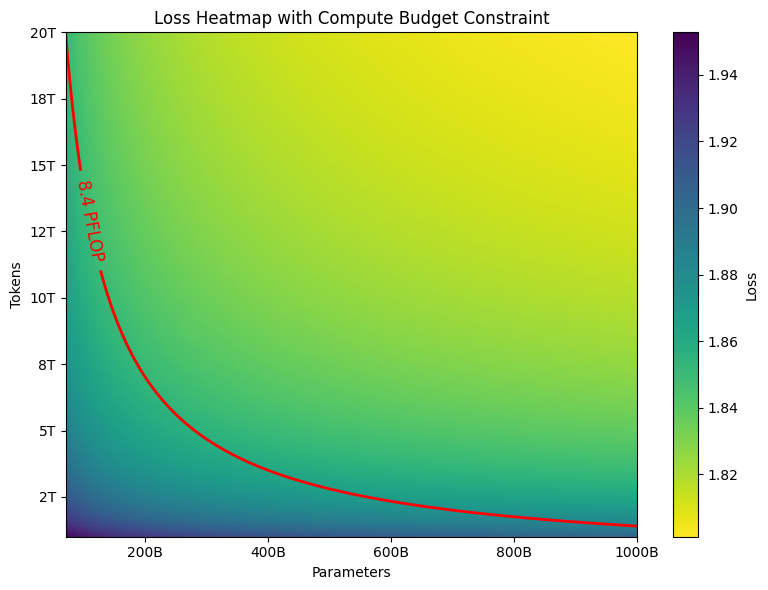

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

# Constants from the Chinchilla scaling law
A = 406.4 
B = 410.7
alpha = 0.34
beta = 0.28

# Loss function 
def loss(params, tokens, A=A, B=B, alpha=alpha, beta=beta):
    return 1.69 + A/(params**alpha) + B/(tokens**beta)

# Compute budget function (in FLOPs)
def compute_budget(params, tokens):
    return 6 * params * tokens

# Range of model sizes and dataset sizes to plot
param_min, param_max = 7e10, 1e12  # 70B to 1T
token_min, token_max = 1e12, 2e13  # 1T to 20T

# Compute budget for a 70B model trained on 20T tokens 
budget_70b_20t = compute_budget(7e10, 2e13)

# Generate meshgrid of params and tokens
params = np.linspace(param_min, param_max, 100)
tokens = np.linspace(token_min, token_max, 100) 
PARAMS, TOKENS = np.meshgrid(params, tokens)

# Compute loss and compute budget
LOSS = loss(PARAMS, TOKENS)
BUDGET = compute_budget(PARAMS, TOKENS)

# Create plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot loss heatmap
im = ax.pcolormesh(PARAMS, TOKENS, LOSS, shading='gouraud', cmap='viridis_r')
fig.colorbar(im, ax=ax, label='Loss')

# Plot compute budget constraint
budget_mask = BUDGET <= budget_70b_20t
budget_contour = ax.contour(PARAMS, TOKENS, BUDGET, levels=[budget_70b_20t], colors='r', linewidths=2)
ax.clabel(budget_contour, inline=True, fontsize=12, fmt=lambda x: f'{x/1e24:.1f} PFLOP')

# Labels and title
ax.set_xlabel('Parameters')
ax.set_ylabel('Tokens')
ax.set_title('Loss Heatmap with Compute Budget Constraint')

# Format x and y tick labels
plt.gca().xaxis.set_major_formatter(lambda x, pos: f'{x/1e9:.0f}B')
plt.gca().yaxis.set_major_formatter(lambda x, pos: f'{x/1e12:.0f}T')

plt.tight_layout()
plt.show()

In [3]:
import numpy as np
import scipy.optimize as opt

# Constants from the Chinchilla scaling law
A = 406.4
B = 410.7 
alpha = 0.34
beta = 0.28

# Loss function
def loss(params, tokens, A=A, B=B, alpha=alpha, beta=beta):
    return 1.69 + A/(params**alpha) + B/(tokens**beta)

# Compute budget function (in FLOPs)
def compute_budget(params, tokens):
    return 6 * params * tokens

# Objective function to minimize (loss)
def objective(x):
    params, tokens = x
    return loss(params, tokens)

# Budget constraint function 
def budget_constraint(x):
    params, tokens = x
    return budget_70b_20t - compute_budget(params, tokens)

# Compute budget for a 70B model trained on 20T tokens
budget_70b_20t = compute_budget(70e9, 200000e9)

# Bounds for model size and dataset size
bounds = ((7e10, 1e12), (1e12, 2e13))  # 70B to 1T params, 1T to 20T tokens

# Initial guess
x0 = np.array([7e10, 2e13])  # 70B params, 20T tokens

# Solve constrained optimization problem
result = opt.minimize(objective, x0, method='SLSQP', 
                      bounds=bounds,
                      constraints=({'type': 'ineq', 'fun': budget_constraint}))

# Extract optimal parameters
params_opt, tokens_opt = result.x

print(f"Optimal model size: {params_opt/1e9:.2f} billion parameters")
print(f"Optimal dataset size: {tokens_opt/1e12:.2f} trillion tokens")
print(f"Minimum loss: {loss(params_opt, tokens_opt):.3f}")

Optimal model size: 70.00 billion parameters
Optimal dataset size: 20.00 trillion tokens
Minimum loss: 1.851
